# Neural Gonna Give You Up - UHack 2017

## Preprocess MIDI Files

In [3]:
import midi
import pandas as pd
import numpy as np
import math

pattern = midi.read_midifile('rick-astley-never-gonna-give-you-up.mid')

In [5]:
import preprocess

x = []
new_pattern=midi.Pattern()

for track in pattern:
    notes, vocab, vocab_reverse = preprocess.preprocess_track(track)
    x.append(notes)
#     print(len(notes))
#   vocab_revs.append(vocab_reverse)

df = pd.DataFrame(x[8]) # Just the drums
# print(df)

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the values
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(df))

df.head()

,0
0,0.000000
1,0.008772
2,0.017544
3,0.008772
4,0.026316


In [8]:
df.describe()

,0
count,6300.000000
mean,0.178726
std,0.118482
min,0.000000
25%,0.105263
50%,0.140351
75%,0.219298
max,1.000000


In [11]:
def load_data(stock, seq_len,  split):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = len(result) * split # Amount of data to train on    
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

## Build Recurrent Neural Network Model

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import time

def build_model(layers):
    model = Sequential()

    for x in range(0,2):
        model.add(LSTM(units = layers[1], input_shape=(None, layers[0]), return_sequences=True))
        #model.add(Dropout(0.4))
    
    model.add(LSTM(units= layers[2], return_sequences=False)) 
    #model.add(Dropout(0.4))

    model.add(Dense(units=layers[2]))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

Using TensorFlow backend.


In [12]:
window = 35 # Another hyperparameter
X_train, y_train, X_test, y_test = load_data(df[::-1], window, 1)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (6264, 35, 1)
y_train (6264,)
X_test (0, 35, 1)
y_test (0,)


In [8]:
model = build_model([1, window, 1])

Compilation Time :  0.028075218200683594


In [9]:
model.fit(X_train, y_train, batch_size=128, epochs=1000, validation_split=0.1, verbose=2)

Train on 5637 samples, validate on 627 samples
Epoch 1/1000
 - 4s - loss: 0.0170 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 2/1000
 - 3s - loss: 0.0138 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 3/1000
 - 2s - loss: 0.0136 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 4/1000
 - 2s - loss: 0.0135 - acc: 0.0000e+00 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 5/1000
 - 2s - loss: 0.0137 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 6/1000
 - 2s - loss: 0.0134 - acc: 0.0000e+00 - val_loss: 0.0105 - val_acc: 0.0000e+00
Epoch 7/1000
 - 2s - loss: 0.0135 - acc: 0.0000e+00 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 8/1000
 - 2s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 9/1000
 - 2s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 10/1000
 - 2s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 11/1000
 - 2s - 

In [10]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

# testScore = model.evaluate(X_test, y_test, verbose=0)
# print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.03 RMSE)


In [11]:
pred = model.predict(X_train)

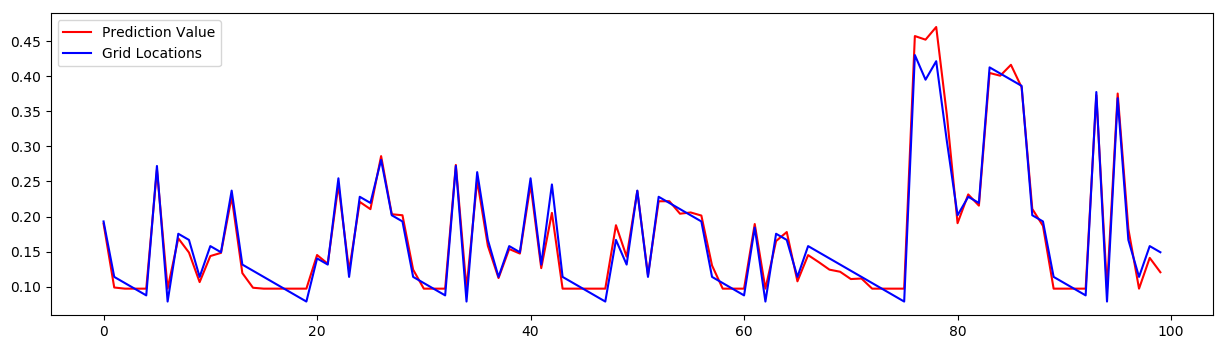

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[500:600], color='red', label='Prediction Value')
plt.plot(y_train[500:600], color='blue', label='Grid Locations')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# cols = []
# for x in range(0, max, seq_len):
#     cols.append(list(range(x, x + seq_len)))
# # print (cols)
# print(len(cols))

In [ ]:
# import numpy as np
# d = {}
# for x in range(855):
#     d[x] = df[list(cols[x])].apply(list, axis=1).T.reset_index(drop=True).T
# df2 = pd.concat(d)

In [ ]:
# (df2.loc[510])

0
1372
2500
312
950
880
240
74
2500
1252
4
6070
0
X_train (1336, 35, 1)
y_train (1336,)


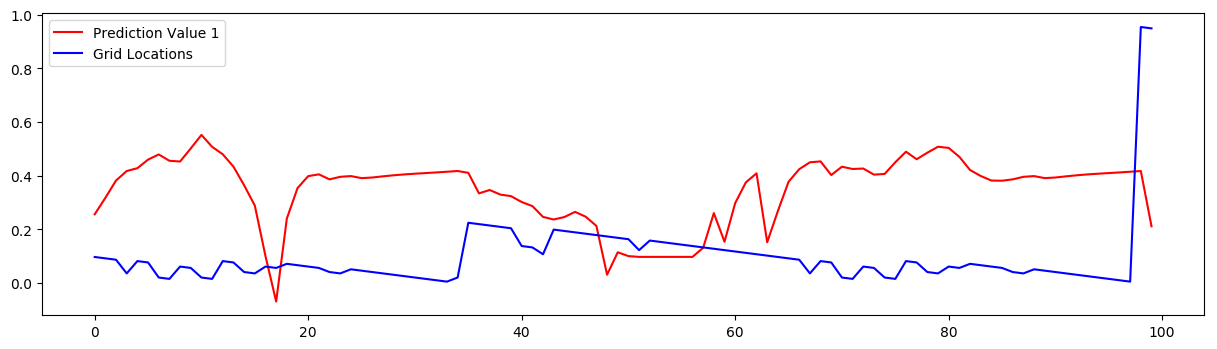

midi.Track(\
  [midi.NoteOnEvent(tick=16, channel=0, data=[53, 81]),
   midi.NoteOffEvent(tick=176, channel=0, data=[41, 81]),
   midi.NoteOffEvent(tick=176, channel=0, data=[41, 81]),
   midi.NoteOffEvent(tick=124, channel=0, data=[39, 81]),
   midi.NoteOffEvent(tick=124, channel=0, data=[39, 81]),
   midi.NoteOnEvent(tick=52, channel=0, data=[53, 81]),
   midi.NoteOnEvent(tick=60, channel=0, data=[46, 81]),
   midi.NoteOnEvent(tick=0, channel=0, data=[51, 81]),
   midi.NoteOnEvent(tick=60, channel=0, data=[46, 81]),
   midi.NoteOnEvent(tick=24, channel=0, data=[53, 81])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=0, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=0, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=0, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=0, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=0, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=0, data=[100, 127]),
   midi.ProgramChangeEvent(tick

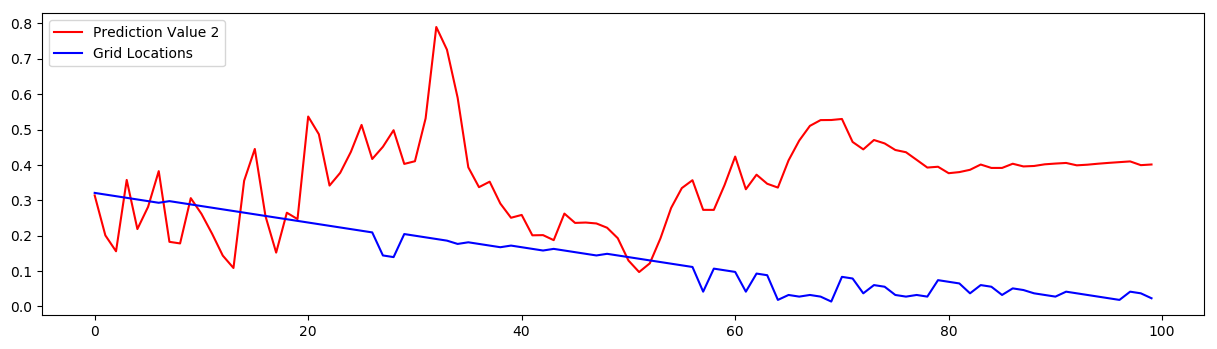

midi.Track(\
  [midi.NoteOnEvent(tick=68, channel=0, data=[34, 82]),
   midi.NoteOnEvent(tick=64, channel=0, data=[36, 93]),
   midi.NoteOffEvent(tick=40, channel=0, data=[41, 80]),
   midi.NoteOnEvent(tick=40, channel=0, data=[41, 91]),
   midi.NoteOffEvent(tick=100, channel=0, data=[36, 93]),
   midi.NoteOnEvent(tick=800, channel=0, data=[34, 110]),
   midi.NoteOffEvent(tick=140, channel=0, data=[34, 91]),
   midi.NoteOffEvent(tick=28, channel=0, data=[39, 85]),
   midi.NoteOnEvent(tick=68, channel=0, data=[39, 80]),
   midi.NoteOnEvent(tick=68, channel=0, data=[39, 80])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=1, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=1, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=1, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=1, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=1, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=1, data=[100, 127]),
   midi.ProgramChangeEvent(tic

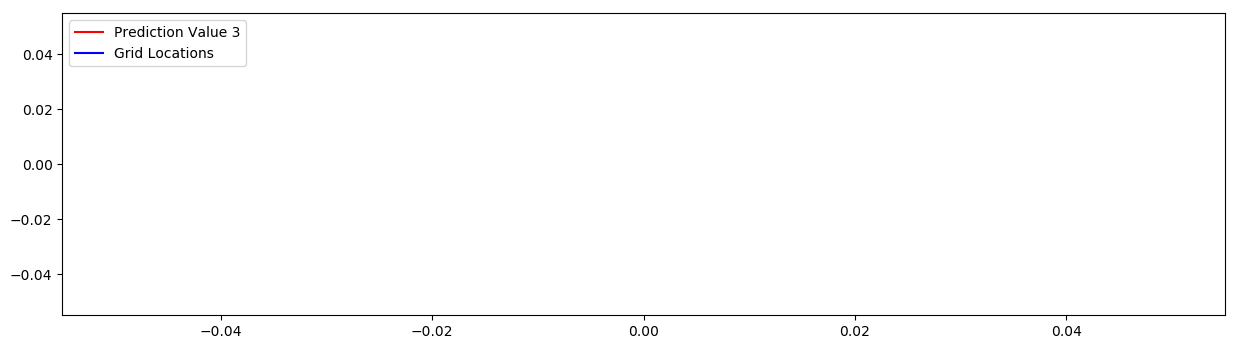

midi.Track(\
  [midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87]),
   midi.NoteOffEvent(tick=68, channel=0, data=[58, 87])])
midi.Track(\
  [midi.ControlChangeEvent(tick=84, channel=2, data=[0, 0]),
   midi.ControlChangeEvent(tick=0, channel=2, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=2, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=2, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=2, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=2, data=[101, 127]),
   midi.ControlChangeEvent(tick

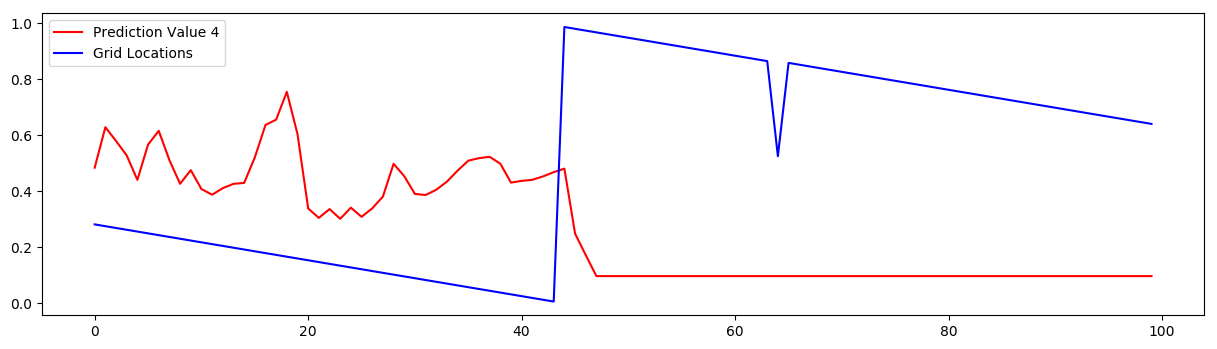

midi.Track(\
  [midi.NoteOffEvent(tick=32, channel=0, data=[70, 98]),
   midi.NoteOnEvent(tick=76, channel=0, data=[74, 107]),
   midi.NoteOffEvent(tick=32, channel=0, data=[67, 74]),
   midi.NoteOffEvent(tick=188, channel=0, data=[65, 60]),
   midi.NoteOnEvent(tick=6220, channel=0, data=[74, 107]),
   midi.NoteOffEvent(tick=92, channel=0, data=[80, 100]),
   midi.NoteOnEvent(tick=84, channel=0, data=[85, 87]),
   midi.NoteOffEvent(tick=100, channel=0, data=[84, 102]),
   midi.NoteOffEvent(tick=4, channel=0, data=[85, 87]),
   midi.NoteOffEvent(tick=72, channel=0, data=[80, 85])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=3, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=3, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=3, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=3, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=3, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=3, data=[100, 127]),
   midi.ProgramChangeEve

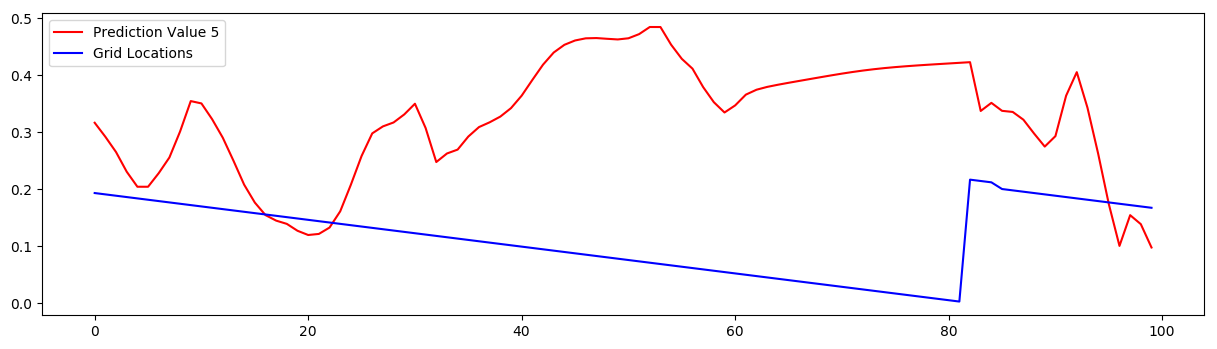

midi.Track(\
  [midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113]),
   midi.NoteOffEvent(tick=96, channel=0, data=[74, 113])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=4, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=4, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=4, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=4, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=4, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=4, data=[100, 127]),
   midi.ProgramCha

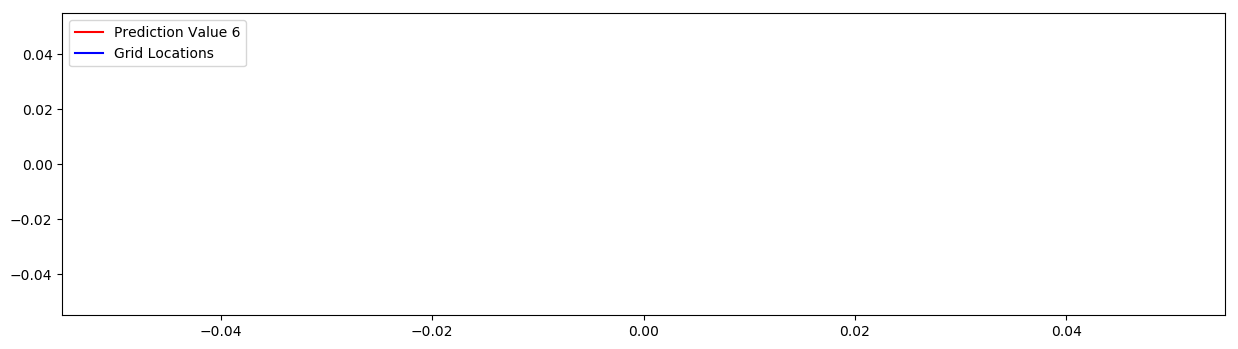

midi.Track(\
  [midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=2924, channel=0, data=[77, 100]),
   midi.NoteOffEvent(tick=80, channel=0, data=[74, 107]),
   midi.NoteOffEvent(tick=260, channel=0, data=[77, 100])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=5, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=5, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=5, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=5, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=5, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=5, data=[100, 127]),
 

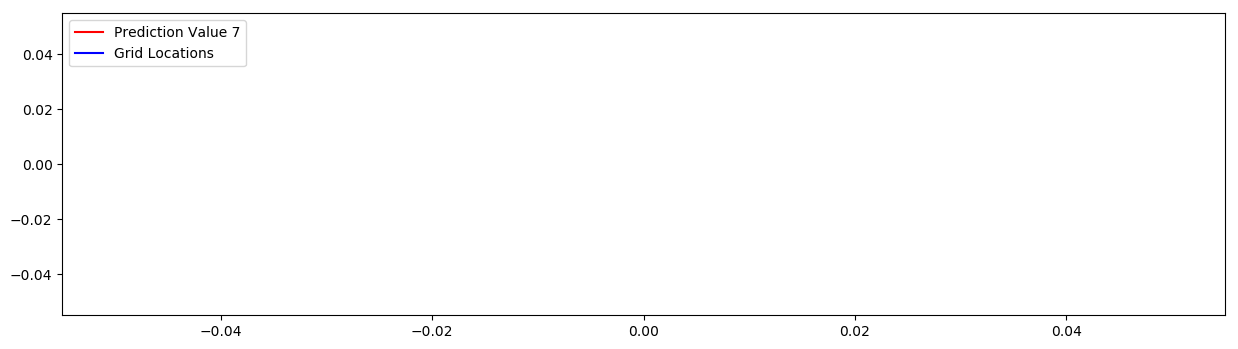

midi.Track(\
  [midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=20, channel=0, data=[84, 91]),
   midi.NoteOnEvent(tick=268, channel=0, data=[85, 102]),
   midi.NoteOffEvent(tick=144, channel=0, data=[84, 89]),
   midi.NoteOffEvent(tick=76, channel=0, data=[82, 78]),
   midi.NoteOnEvent(tick=216, channel=0, data=[85, 89])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=6, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=6, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=6, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=6, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=6, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=6, data=[100, 127]),
   midi.ProgramChangeEvent(tick=

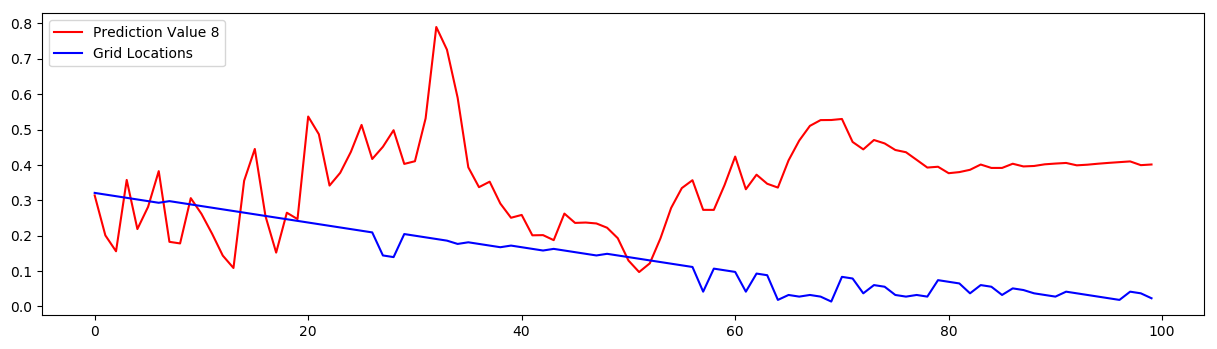

midi.Track(\
  [midi.NoteOnEvent(tick=68, channel=0, data=[46, 69]),
   midi.NoteOnEvent(tick=64, channel=0, data=[48, 80]),
   midi.NoteOffEvent(tick=40, channel=0, data=[53, 67]),
   midi.NoteOnEvent(tick=40, channel=0, data=[53, 78]),
   midi.NoteOffEvent(tick=100, channel=0, data=[48, 80]),
   midi.NoteOnEvent(tick=800, channel=0, data=[46, 97]),
   midi.NoteOffEvent(tick=140, channel=0, data=[46, 78]),
   midi.NoteOffEvent(tick=28, channel=0, data=[51, 72]),
   midi.NoteOnEvent(tick=68, channel=0, data=[51, 67]),
   midi.NoteOnEvent(tick=68, channel=0, data=[51, 67])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=7, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=7, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=7, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=7, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=7, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=7, data=[100, 127]),
   midi.ProgramChangeEvent(tick

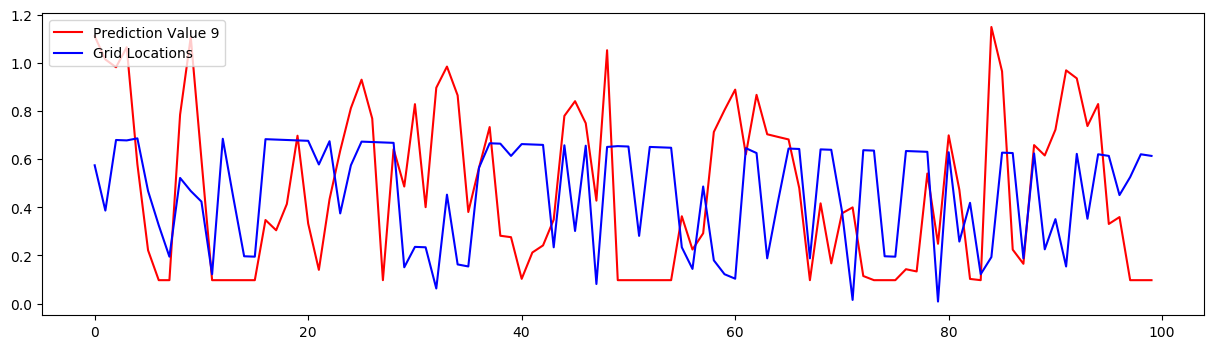

midi.Track(\
  [midi.NoteOffEvent(tick=80, channel=0, data=[65, 80]),
   midi.NoteOffEvent(tick=84, channel=0, data=[58, 95]),
   midi.NoteOnEvent(tick=0, channel=0, data=[70, 100]),
   midi.NoteOnEvent(tick=304, channel=0, data=[58, 82]),
   midi.NoteOffEvent(tick=68, channel=0, data=[65, 102]),
   midi.NoteOffEvent(tick=24, channel=0, data=[58, 74]),
   midi.NoteOffEvent(tick=4, channel=0, data=[58, 95]),
   midi.NoteOnEvent(tick=312, channel=0, data=[58, 85]),
   midi.NoteOnEvent(tick=0, channel=0, data=[70, 76]),
   midi.NoteOffEvent(tick=80, channel=0, data=[65, 89])])
midi.Track(\
  [midi.ControlChangeEvent(tick=0, channel=8, data=[32, 0]),
   midi.ControlChangeEvent(tick=96, channel=8, data=[101, 0]),
   midi.ControlChangeEvent(tick=0, channel=8, data=[100, 0]),
   midi.ControlChangeEvent(tick=0, channel=8, data=[6, 2]),
   midi.ControlChangeEvent(tick=96, channel=8, data=[101, 127]),
   midi.ControlChangeEvent(tick=0, channel=8, data=[100, 127]),
   midi.ProgramChangeEvent(tick

In [84]:
# import math
# import preprocess
# import matplotlib.pyplot as plt

# x = []
# vocab_revs=[]
# new_pattern=midi.Pattern()
# pattern = midi.read_midifile('cottoneyejoe.mid')

for track in pattern:
    notes, vocab, vocab_reverse = preprocess.preprocess_track(track)
    x.append(notes)
    print(len(notes))
    vocab_revs.append(vocab_reverse)
final_generated_pattern=midi.Pattern()

for i in range(1,10):
    window = 35 # Another hyperparameter
    
    df = pd.DataFrame(x[i])
    scaler = MinMaxScaler(feature_range=(0, 1))
    temp_df = pd.DataFrame(scaler.fit_transform(df))
    
    X_train, y_train, X_test, y_test = load_data(temp_df[::-1], window, 1)
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    pred = model.predict(X_train)
    
    plt.figure(figsize=(15, 4), dpi=100)
    plt.plot(pred[500:600], color='red', label='Prediction Value ' + str(i))
    plt.plot(y_train[500:600], color='blue', label='Grid Locations')
    plt.legend(loc='upper left')

    plt.show()

    denormalized= scaler.inverse_transform(pred)
    map(round,denormalized)
    denormalized = [int(item) for sublist in denormalized for item in sublist]
    tnotes, tvocab, tvocab_reverse = preprocess.preprocess_track(pattern[i])
    midi_pred_events = preprocess.events_to_midi([vocab_revs[i][t%len(vocab_revs[i])] for t in denormalized],pattern.resolution)
    try:
        for event in midi_pred_events[0]:
            event.channel=pattern[i][0].channel
    except AttributeError:
        pass
    new_pattern = midi.Pattern()
    new_pattern.append(midi_pred_events[0])
    final_generated_pattern.append(midi_pred_events[0])
    new_pattern.resolution=pattern.resolution
    midi.write_midifile("generated" + str(i) + ".mid", new_pattern)

    ##For comparison, we write track 9
    test_pattern=midi.Pattern()
    test_pattern.append(pattern[i])
    test_pattern.resolution=pattern.resolution
    # b = preprocess.events_to_midi([tvocab_reverse[t] for t in tnotes],pattern.resolution)
    # test_pattern.append(b[0])
    midi.write_midifile("test.mid", test_pattern)
    print(new_pattern[0][0:10])
    print(test_pattern[0][4:14])

    final_generated_pattern.resolution=pattern.resolution
    midi.write_midifile("generated_all.mid", final_generated_pattern)

In [ ]:
# pattern.make_ticks_abs()
# tracks_we_care_about = pattern[1:9]
# processed_tracks = []
# max = 0
# for track in tracks_we_care_about:
#     if track[-1].tick>max:
#         max = track[-1].tick

# seq_len = 256
# max = math.ceil(max/seq_len)*seq_len-1 
# print(max)
        
# for track in tracks_we_care_about:
#     channel = track[0].channel
#     processed_tracks.append([[channel,0,0]]*(max+1))
#     for note in track:
#         if isinstance(note,midi.events.NoteOnEvent):
#             processed_tracks[-1][note.tick]=[channel,note.data[0],note.data[1]]
            
# df = pd.DataFrame(processed_tracks)
# print(df) 